In [40]:
! pip install numpy matplotlib opencv-python scikit-learn scikit-image tensorflow keras pandas seaborn tqdm mtcnn lz4 facenet_pytorch xgboost

  Using cached xgboost-3.0.5-py3-none-win_amd64.whl.metadata (2.1 kB)
Using cached xgboost-3.0.5-py3-none-win_amd64.whl (56.8 MB)


In [ ]:
import numpy as np
from utils import canny, load_fer2013_data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Linear models
from sklearn.linear_model import LogisticRegression, Ridge, Lasso

# Tree-based models
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier

# SVM models
from sklearn.svm import LinearSVC, SVC

# Naive Bayes
from sklearn.naive_bayes import GaussianNB

# KNN
from sklearn.neighbors import KNeighborsClassifier

# Metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score


import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tqdm import tqdm
import cv2
from facenet_pytorch import MTCNN
import lz4 


from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier 

d:\HCMUT\Computer Vision\IPCV_Project\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
X, y, emotion_labels = load_fer2013_data('data/train')
print(f"Dataset shape: {X.shape}")
print(f"Labels shape: {y.shape}")
print(f"Emotion labels: {emotion_labels}")

Loading and preprocessing images...
Processing angry: 3995 images


Loading angry: 100%|██████████| 3995/3995 [00:24<00:00, 163.04it/s]


Processing disgust: 436 images


Loading disgust: 100%|██████████| 436/436 [00:02<00:00, 157.48it/s]


Processing fear: 4097 images


Loading fear: 100%|██████████| 4097/4097 [00:27<00:00, 148.01it/s]


Processing happy: 7215 images


Loading happy: 100%|██████████| 7215/7215 [00:47<00:00, 150.60it/s]


Processing sad: 4830 images


Loading sad: 100%|██████████| 4830/4830 [00:30<00:00, 157.59it/s]


Processing surprise: 3171 images


Loading surprise: 100%|██████████| 3171/3171 [00:01<00:00, 3152.40it/s]


Processing neutral: 4965 images


Loading neutral: 100%|██████████| 4965/4965 [00:01<00:00, 3677.62it/s]


Dataset shape: (28709, 48, 48)
Labels shape: (28709,)
Emotion labels: ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']


In [3]:
# Baseline Training - Simple encoding and ML training

# 1. Preprocess and encode data
def preprocess_images(X, target_size=(48, 48)):
    """
    Preprocess images: resize and flatten to vector
    """
    processed = []
    
    print("Preprocessing images...")
    for img in tqdm(X):
        # Resize if needed
        if img.shape != target_size:
            img_resized = cv2.resize(img, target_size)
        else:
            img_resized = img
        
        # Flatten to 1D vector
        img_flattened = img_resized.flatten()
        processed.append(img_flattened)
    
    return np.array(processed)

# 2. Encode data
print("Encoding images to vectors...")
X_encoded = preprocess_images(X, target_size=(48, 48))
print(f"Encoded shape: {X_encoded.shape}")  # Should be (n_samples, 2304)



Encoding images to vectors...
Preprocessing images...


100%|██████████| 28709/28709 [00:00<00:00, 197524.14it/s]


Encoded shape: (28709, 2304)


In [4]:
#  logistic regression , SVM , Decision Tree , Random Forest 
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Linear SVM": LinearSVC(max_iter=1000) , 
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=100)
}

In [5]:
# Detailed evaluation and visualization

def evaluate_models(model_results, y_test, emotion_labels):
    """
    Detailed evaluation of all trained models
    """
    print("\n" + "=" * 60)
    print("DETAILED MODEL EVALUATION")
    print("=" * 60)
    
    # Extract results
    model_names = list(model_results.keys())
    accuracies = [model_results[name]['accuracy'] for name in model_names]
    
    # 1. Accuracy comparison plot
    plt.figure(figsize=(15, 5))
    
    plt.subplot(1, 3, 1)
    colors = ['blue', 'green', 'red', 'orange']
    bars = plt.bar(model_names, accuracies, color=colors, alpha=0.7)
    plt.title('Model Accuracy Comparison')
    plt.ylabel('Accuracy')
    plt.xticks(rotation=45)
    plt.ylim(0, 1)
    
    # Add accuracy values on bars
    for bar, acc in zip(bars, accuracies):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                f'{acc:.3f}', ha='center', va='bottom')
    
    # 2. Precision, Recall, F1 comparison
    plt.subplot(1, 3, 2)
    metrics_data = []
    for name in model_names:
        report = model_results[name]['classification_report']
        metrics_data.append([
            report['macro avg']['precision'],
            report['macro avg']['recall'],
            report['macro avg']['f1-score']
        ])
    
    metrics_data = np.array(metrics_data)
    x = np.arange(len(model_names))
    width = 0.25
    
    plt.bar(x - width, metrics_data[:, 0], width, label='Precision', alpha=0.7)
    plt.bar(x, metrics_data[:, 1], width, label='Recall', alpha=0.7)
    plt.bar(x + width, metrics_data[:, 2], width, label='F1-Score', alpha=0.7)
    
    plt.xlabel('Models')
    plt.ylabel('Score')
    plt.title('Macro-averaged Metrics')
    plt.xticks(x, model_names, rotation=45)
    plt.legend()
    plt.ylim(0, 1)
    
    # 3. Summary table
    plt.subplot(1, 3, 3)
    summary_data = []
    for name in model_names:
        report = model_results[name]['classification_report']
        summary_data.append([
            name[:10] + '...' if len(name) > 10 else name,
            f"{model_results[name]['accuracy']:.3f}",
            f"{report['macro avg']['f1-score']:.3f}"
        ])
    
    plt.axis('tight')
    plt.axis('off')
    table = plt.table(cellText=summary_data,
                     colLabels=['Model', 'Accuracy', 'F1-Score'],
                     cellLoc='center',
                     loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1.2, 1.5)
    plt.title('Results Summary')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed classification reports
    for model_name, result in model_results.items():
        print(f"\n{model_name.upper()} - Classification Report:")
        print("-" * 50)
        print(classification_report(y_test, result['predictions'], target_names=emotion_labels))


In [6]:
# Save the best model and create final summary

def save_best_model(model_results, emotion_labels):
    """
    Save the best performing model and create final summary
    """
    import joblib
    
    # Find best model
    best_model_name = max(model_results.keys(), key=lambda k: model_results[k]['accuracy'])
    best_model = model_results[best_model_name]['model']
    best_accuracy = model_results[best_model_name]['accuracy']
    
    # Create summary DataFrame
    summary_data = []
    for model_name, result in model_results.items():
        summary_data.append({
            'Model': model_name,
            'Accuracy': result['accuracy'],
            'Precision_macro': result['classification_report']['macro avg']['precision'],
            'Recall_macro': result['classification_report']['macro avg']['recall'],
            'F1_macro': result['classification_report']['macro avg']['f1-score']
        })
    
    summary_df = pd.DataFrame(summary_data)
    summary_df = summary_df.sort_values('Accuracy', ascending=False)
    
    print("\n" + "=" * 60)
    print("FINAL BASELINE RESULTS SUMMARY")
    print("=" * 60)
    print(summary_df.round(4).to_string(index=False))
    
    print(f"\nBest Model: {best_model_name}")
    print(f"Best Accuracy: {best_accuracy:.4f}")
    
    # Package everything for saving
    model_package = {
        'best_model': best_model,
        'best_model_name': best_model_name,
        'emotion_labels': emotion_labels,
        'all_results': model_results,
        'summary': summary_df,
        'target_size': (48, 48)
    }
    
    # Save to file
    joblib.dump(model_package, 'data/baseline_emotion_models.pkl')
    print(f"\nAll models and preprocessing components saved to 'baseline_emotion_models.pkl'")
    
    return summary_df, best_model_name


# Pipeline Experiment A: HOG + SVM-RBF + ROI

## 1. Dataset & Split
- Dataset: FER2013 / RAF-DB (7 lớp cảm xúc).
- Input: ảnh khuôn mặt đã crop.
- Chia tập: Train 70% – Val 15% – Test 15% (stratified).

---
## 2. Meadian filer + CLAHE 

## 3. Resize + Normalize
---

## 4. Feature Extraction (HOG)
  - orientations = 9  
  - pixels_per_cell = 8×8  
  - cells_per_block = 2×2  
  - block_stride = 8  
  - transform_sqrt = True  
- Chuẩn hóa bằng StandardScaler.
- PCA (95% phương sai) để giảm chiều.

---

## 5. Model Training
- Classifier: **SVM-RBF** , **Random Forest** , **Logistic Regression** , 

## Tunning Model 
- Grid search:
  - C ∈ {1, 4, 8, 16}
  - γ ∈ {1/d, 2/d, 4/d} (d = số chiều sau PCA).
- Đánh giá bằng Stratified 5-fold CV.
- Train lại với tham số tối ưu trên train+val → test cuối.
---

## 6. Evaluation
- **Chỉ số chính**: Macro-F1.
- Phụ: Accuracy, per-class F1, Confusion matrix.
- Phân tích lỗi: fear ↔ surprise, disgust ↔ sad/angry.



## Preprocessing 
- CLAHE 
- Meadian Filter 
- GF, ER , MR 

In [7]:
def plot_transformation_comparison(X_original, X_transformed, transformation_name, 
                                 emotion_labels, y, n_samples=8, figsize=(20, 8)):
    """
    Universal function to plot comparison between original and transformed images
    
    Parameters:
    - X_original: Original images
    - X_transformed: Transformed images  
    - transformation_name: Name of the transformation (e.g., "CLAHE", "Median Filter")
    - emotion_labels: List of emotion labels
    - y: Label array
    - n_samples: Number of samples to display
    - figsize: Figure size
    """
    # Randomly select some indices for visualization
    indices = np.random.choice(len(X_original), n_samples, replace=False)
    
    fig, axes = plt.subplots(2, n_samples, figsize=figsize)
    
    for i, idx in enumerate(indices):
        # Original image
        orig_img = X_original[idx]
        
        # Handle different data ranges for display
        if orig_img.max() <= 1.0:
            orig_vmin, orig_vmax = 0, 1
        else:
            orig_vmin, orig_vmax = 0, 255
            
        axes[0, i].imshow(orig_img, cmap='gray', vmin=orig_vmin, vmax=orig_vmax)
        axes[0, i].set_title(f'Original\n{emotion_labels[y[idx]]}', fontsize=10)
        axes[0, i].axis('off')
        
        # Transformed image
        trans_img = X_transformed[idx]
        
        # Handle different data ranges for display
        if trans_img.max() <= 1.0:
            trans_vmin, trans_vmax = 0, 1
        else:
            trans_vmin, trans_vmax = 0, 255
            
        axes[1, i].imshow(trans_img, cmap='gray', vmin=trans_vmin, vmax=trans_vmax)
        axes[1, i].set_title(f'{transformation_name}\n{emotion_labels[y[idx]]}', fontsize=10)
        axes[1, i].axis('off')
    
    plt.suptitle(f'Original vs {transformation_name} Enhanced Images', fontsize=16)
    plt.tight_layout()
    plt.show()


In [8]:
X_median_filtered = np.array([cv2.medianBlur(img, 3) for img in X])  


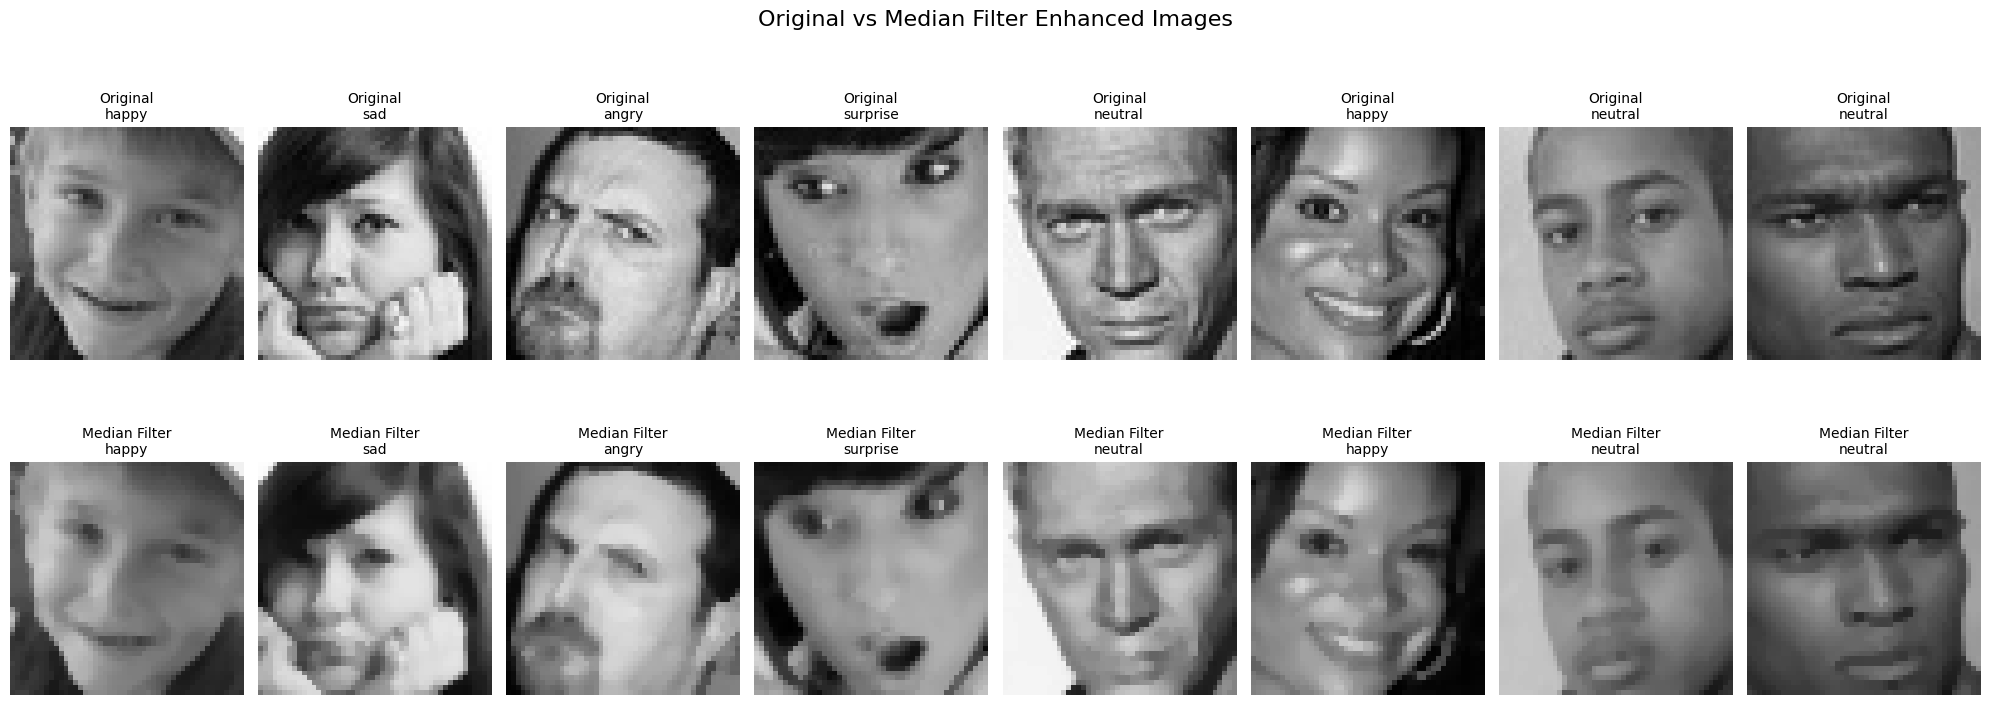

In [9]:
plot_transformation_comparison(X, X_median_filtered, "Median Filter", emotion_labels, y, n_samples=8)

In [10]:
# Apply clahe to enhance image contrast
def apply_clahe(X, clip_limit=2.0, tile_grid_size=(8, 8)):
    """
    Apply CLAHE (Contrast Limited Adaptive Histogram Equalization) to enhance image contrast
    """
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)
    enhanced_images = []
    
    print("Applying CLAHE to images...")
    for img in tqdm(X):
        # Convert to uint8 if needed
        if img.dtype != np.uint8:
            # Normalize to 0-255 range if needed
            if img.max() <= 1.0:  # If image is in [0,1] range
                img_uint8 = (img * 255).astype(np.uint8)
            else:  # If image is already in [0,255] range but wrong dtype
                img_uint8 = np.clip(img, 0, 255).astype(np.uint8)
        else:
            img_uint8 = img
        
        # Apply CLAHE
        img_enhanced = clahe.apply(img_uint8)
        enhanced_images.append(img_enhanced)
    
    return np.array(enhanced_images)

Applying CLAHE to images...


100%|██████████| 28709/28709 [00:01<00:00, 27112.67it/s]


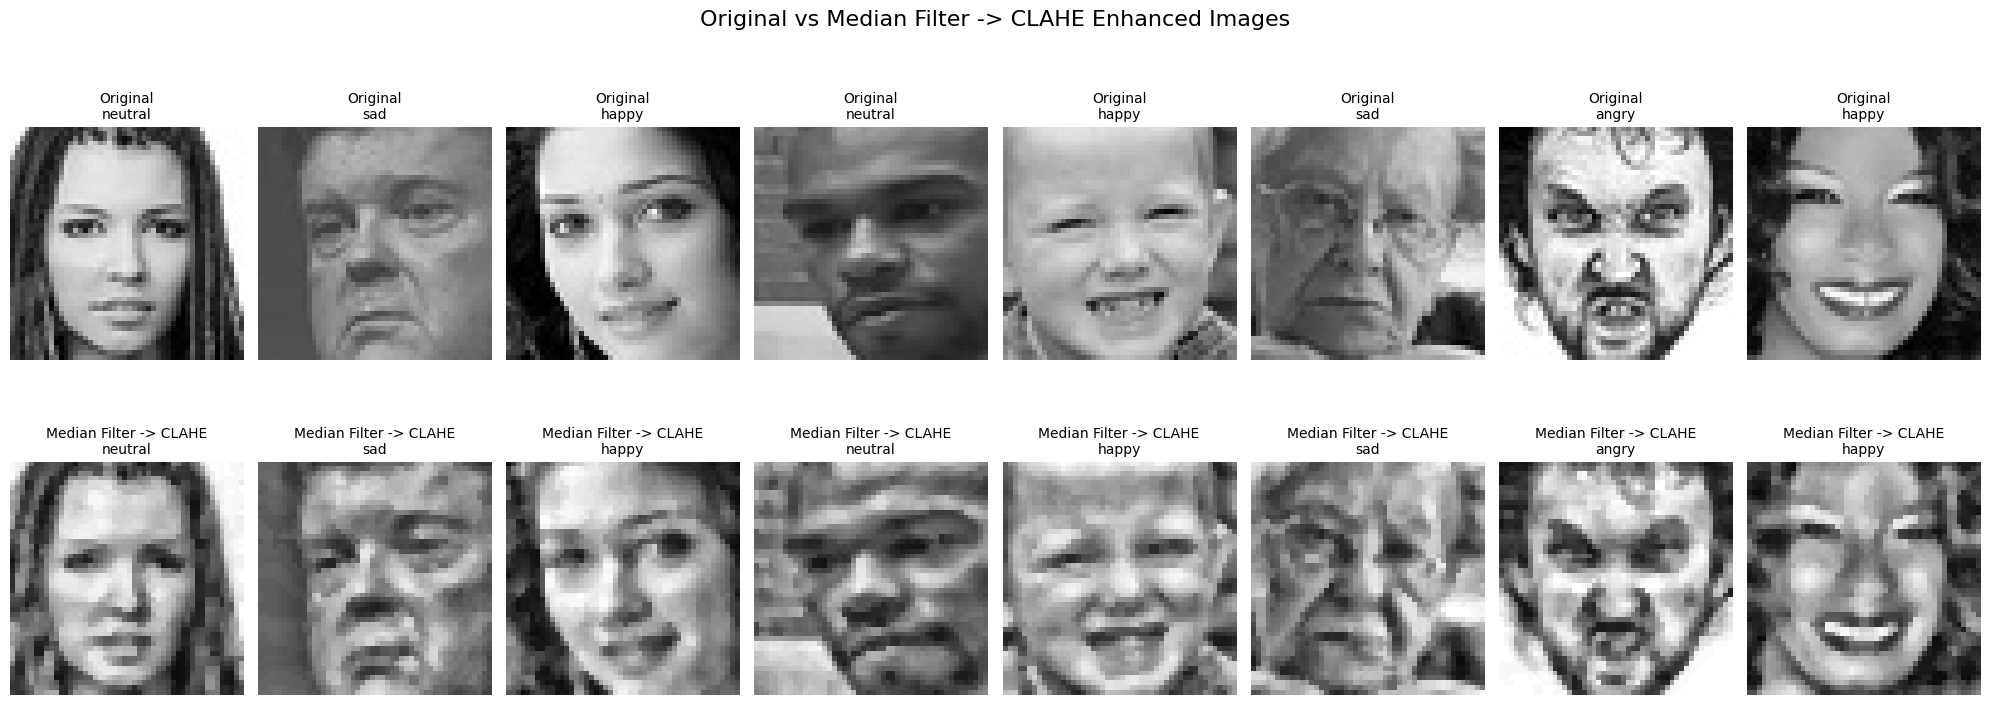

In [11]:
x_median_clahe = apply_clahe(X_median_filtered, clip_limit=2.0, tile_grid_size=(8, 8)) 
plot_transformation_comparison(X, x_median_clahe, "Median Filter -> CLAHE", emotion_labels, y, n_samples=8)

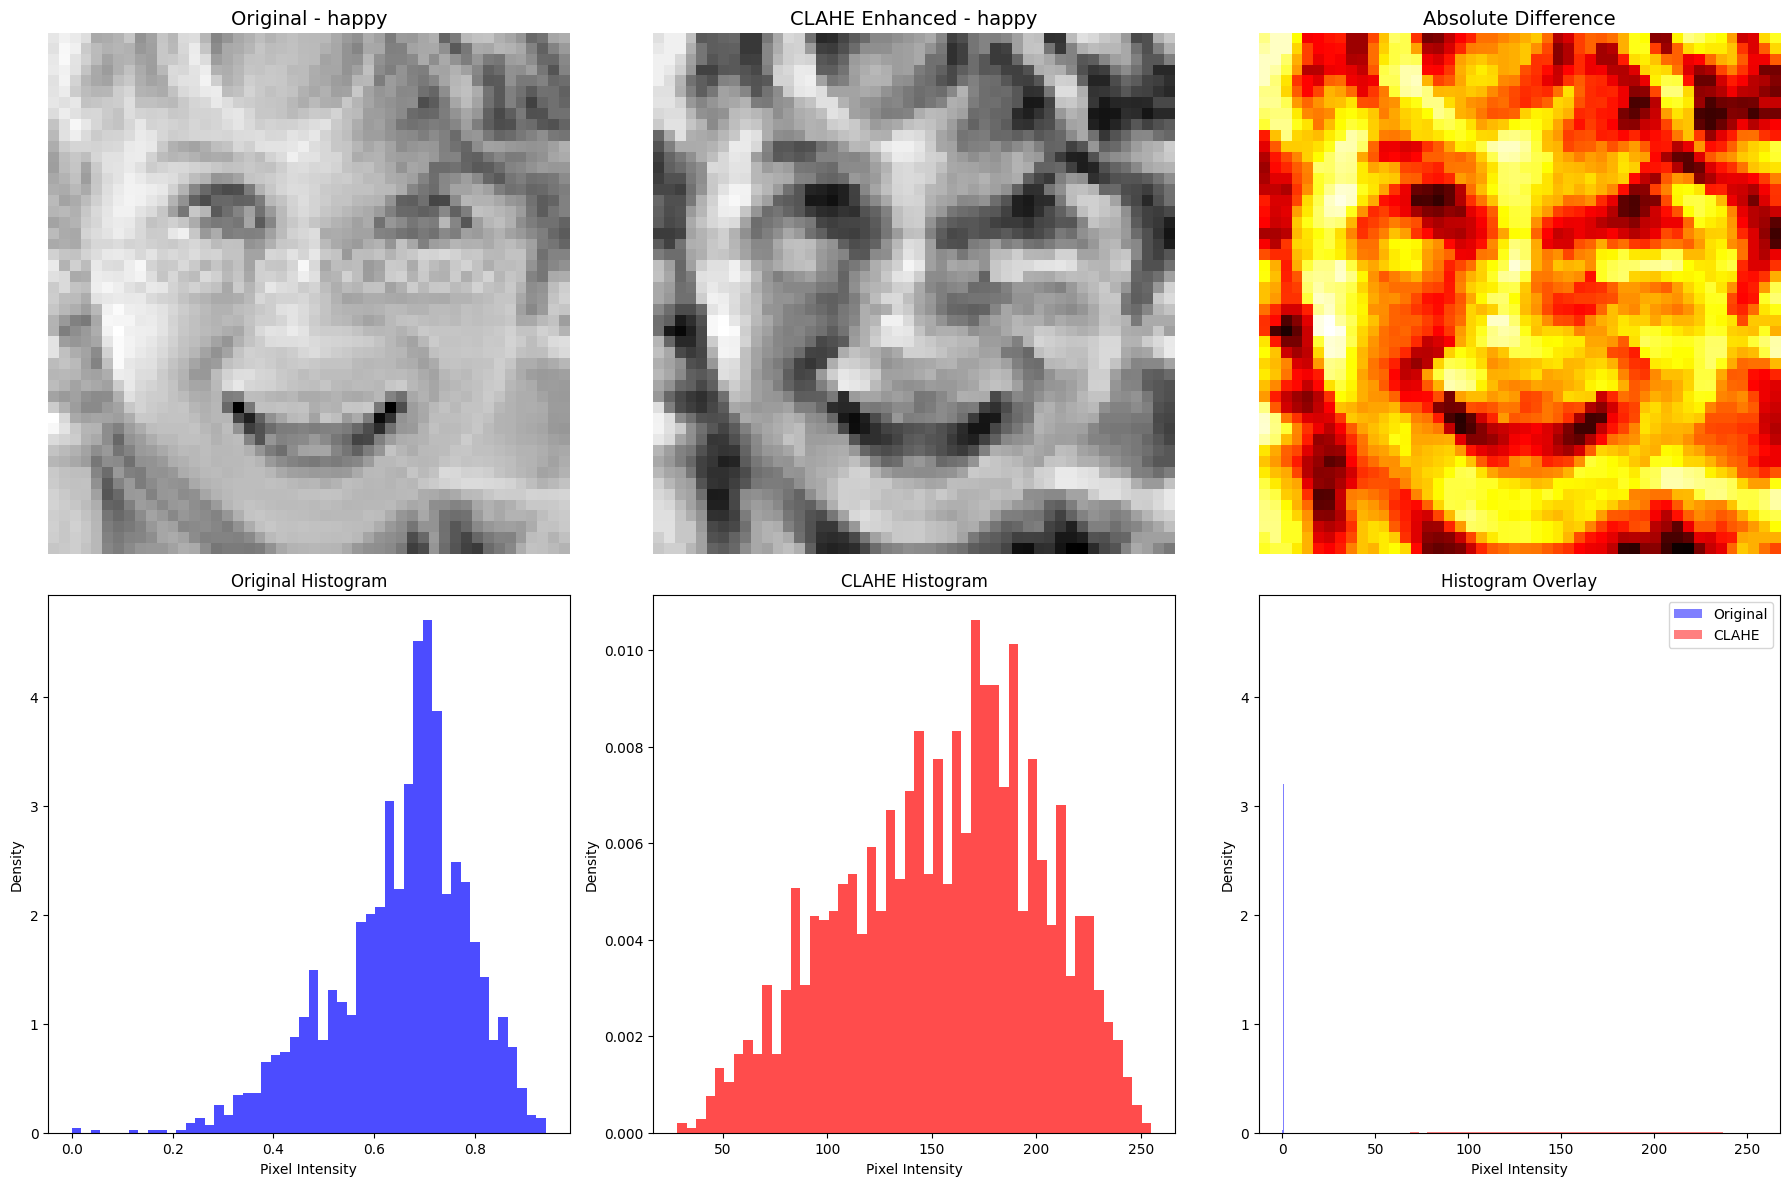

Image Statistics for sample 11646 (happy):
Original  - Mean: 0.65, Std: 0.13
CLAHE     - Mean: 154.66, Std: 46.76
Contrast improvement: 46.62


In [12]:
# Side-by-side detailed comparison with zoom

def detailed_clahe_comparison(X_original, X_clahe, emotion_labels, y, sample_idx=None):
    """
    Detailed side-by-side comparison with zoomed regions
    """
    if sample_idx is None:
        sample_idx = np.random.randint(0, len(X_original))
    
    orig_img = X_original[sample_idx]
    clahe_img = X_clahe[sample_idx]
    emotion = emotion_labels[y[sample_idx]]
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    
    # Full images
    axes[0, 0].imshow(orig_img, cmap='gray')
    axes[0, 0].set_title(f'Original - {emotion}', fontsize=14)
    axes[0, 0].axis('off')
    
    axes[0, 1].imshow(clahe_img, cmap='gray')
    axes[0, 1].set_title(f'CLAHE Enhanced - {emotion}', fontsize=14)
    axes[0, 1].axis('off')
    
    # Difference image
    diff_img = np.abs(clahe_img.astype(float) - orig_img.astype(float))
    axes[0, 2].imshow(diff_img, cmap='hot')
    axes[0, 2].set_title('Absolute Difference', fontsize=14)
    axes[0, 2].axis('off')
    
    # Histograms
    axes[1, 0].hist(orig_img.flatten(), bins=50, alpha=0.7, color='blue', density=True)
    axes[1, 0].set_title('Original Histogram')
    axes[1, 0].set_xlabel('Pixel Intensity')
    axes[1, 0].set_ylabel('Density')
    
    axes[1, 1].hist(clahe_img.flatten(), bins=50, alpha=0.7, color='red', density=True)
    axes[1, 1].set_title('CLAHE Histogram')
    axes[1, 1].set_xlabel('Pixel Intensity')
    axes[1, 1].set_ylabel('Density')
    
    # Overlay histograms
    axes[1, 2].hist(orig_img.flatten(), bins=50, alpha=0.5, color='blue', density=True, label='Original')
    axes[1, 2].hist(clahe_img.flatten(), bins=50, alpha=0.5, color='red', density=True, label='CLAHE')
    axes[1, 2].set_title('Histogram Overlay')
    axes[1, 2].set_xlabel('Pixel Intensity')
    axes[1, 2].set_ylabel('Density')
    axes[1, 2].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print statistics for this specific image
    print(f"Image Statistics for sample {sample_idx} ({emotion}):")
    print(f"Original  - Mean: {np.mean(orig_img):.2f}, Std: {np.std(orig_img):.2f}")
    print(f"CLAHE     - Mean: {np.mean(clahe_img):.2f}, Std: {np.std(clahe_img):.2f}")
    print(f"Contrast improvement: {np.std(clahe_img) - np.std(orig_img):.2f}")

# Show detailed comparison for a random sample
detailed_clahe_comparison(X, x_median_clahe, emotion_labels=emotion_labels, y=y)

## Resize and normalize 

In [13]:
# Resize to (64, 64) and normalize to [0, 1]
x_resized = np.array([cv2.resize(img, (64, 64)) for img in x_median_clahe])
x_preprocessed = x_resized.astype('float32') / 255.0
x_preprocessed = x_preprocessed.reshape(-1, 64, 64, 1)  # Add channel dimension


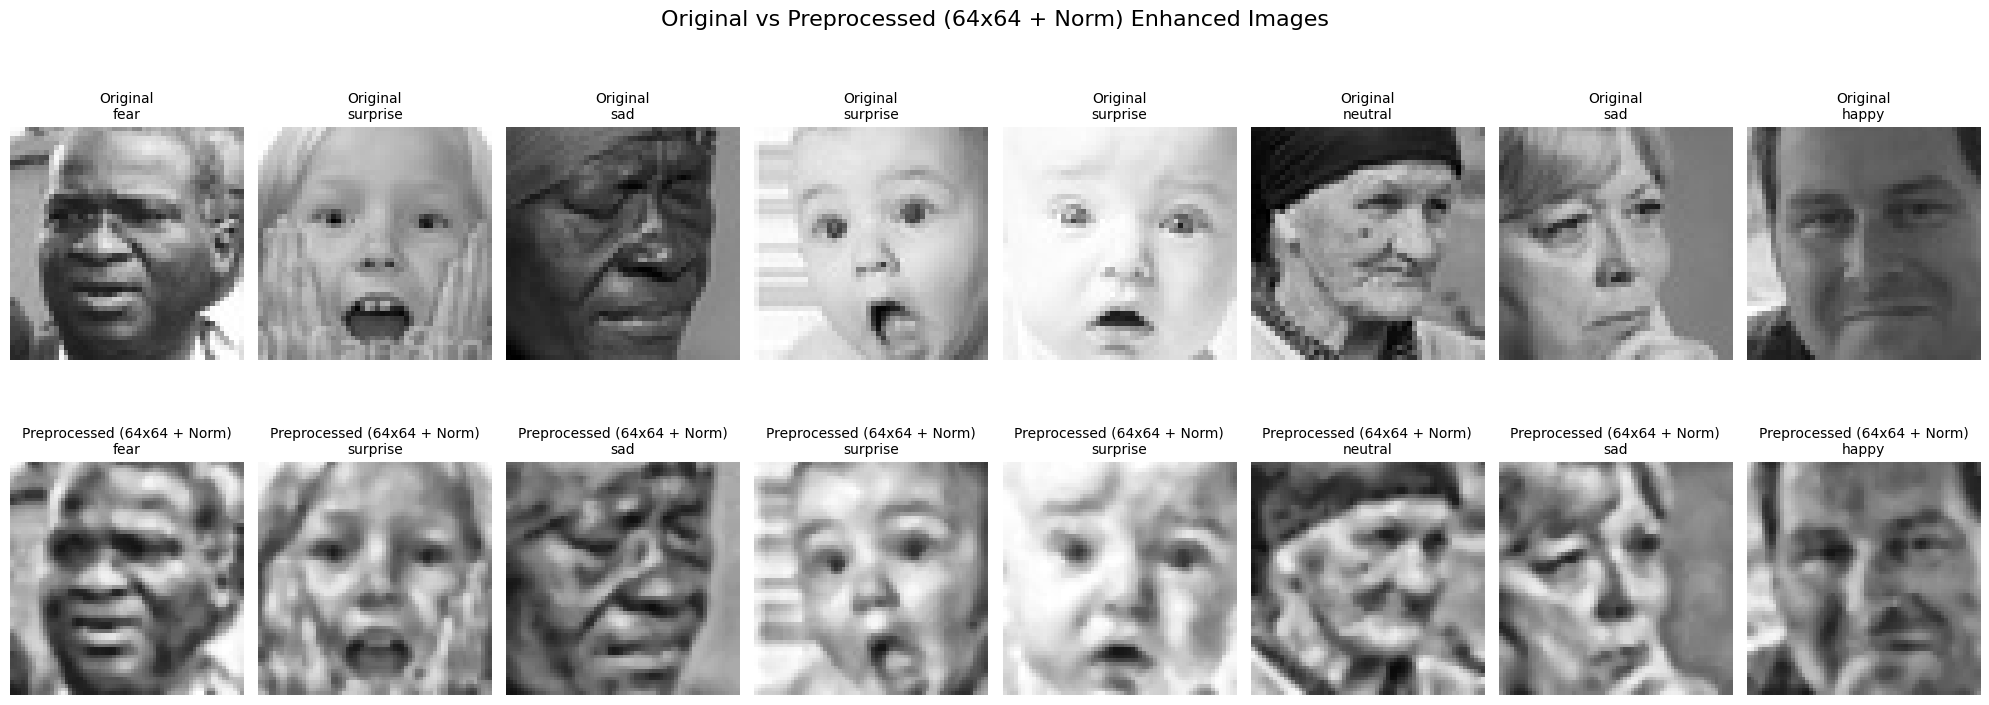

In [14]:
plot_transformation_comparison(X , x_preprocessed, "Preprocessed (64x64 + Norm)", emotion_labels, y, n_samples=8 )

## HOG

In [15]:
from skimage.feature import hog
x_hog = []
for img in tqdm(x_preprocessed):
    hog_features = hog(
        img.squeeze(),
        pixels_per_cell=(8, 8),
        cells_per_block=(2, 2),
        visualize=False    )
    x_hog.append(hog_features)
x_hog = np.array(x_hog)
print(f"HOG feature shape: {x_hog.shape}")


100%|██████████| 28709/28709 [00:26<00:00, 1086.19it/s]


HOG feature shape: (28709, 1764)


## Prepare for Model 

- Standard scaler 
- PCA 

In [16]:
# standard scaler
scaler = StandardScaler()
x_hog_scaled = scaler.fit_transform(x_hog)
# PCA 
pca = PCA(n_components=0.95, random_state=42)  # Retain 95% variance
x_hog_pca = pca.fit_transform(x_hog_scaled)
print(f"PCA reduced shape: {x_hog_pca.shape}")

PCA reduced shape: (28709, 465)


## Prepare test data


In [17]:
X_test , y_test , labels = load_fer2013_data('data/test') 


Loading and preprocessing images...
Processing angry: 958 images


Loading angry: 100%|██████████| 958/958 [00:00<00:00, 7314.21it/s]


Processing disgust: 111 images


Loading disgust: 100%|██████████| 111/111 [00:00<00:00, 8369.91it/s]


Processing fear: 1024 images


Loading fear: 100%|██████████| 1024/1024 [00:00<00:00, 7369.35it/s]


Processing happy: 1774 images


Loading happy: 100%|██████████| 1774/1774 [00:00<00:00, 6952.33it/s]


Processing sad: 1247 images


Loading sad: 100%|██████████| 1247/1247 [00:00<00:00, 7371.64it/s]


Processing surprise: 831 images


Loading surprise: 100%|██████████| 831/831 [00:00<00:00, 7455.29it/s]


Processing neutral: 1233 images


Loading neutral: 100%|██████████| 1233/1233 [00:00<00:00, 7291.75it/s]


In [18]:
def preprocess_test_data(X_test, scaler, pca, target_size=(64, 64)):
    """
    Preprocess test data using the same pipeline as training data
    
    Parameters:
    - X_test: Raw test images
    - scaler: Fitted StandardScaler from training
    - pca: Fitted PCA from training
    - target_size: Target image size (default: (64, 64))
    
    Returns:
    - X_test_processed: Preprocessed test data ready for model prediction
    - preprocessing_info: Dictionary containing intermediate results for analysis
    """
    
    print("🔄 Processing test data through the same pipeline...")
    print("=" * 60)
    
    # Store intermediate results for analysis
    preprocessing_info = {}
    
    # Step 1: Median Filter
    print("Step 1/6: Applying Median Filter...")
    X_test_median = np.array([cv2.medianBlur(img, 3) for img in tqdm(X_test)])
    preprocessing_info['median_filtered'] = X_test_median
    
    # Step 2: CLAHE Enhancement
    print("Step 2/6: Applying CLAHE Enhancement...")
    X_test_clahe = apply_clahe(X_test_median, clip_limit=2.0, tile_grid_size=(8, 8))
    preprocessing_info['clahe_enhanced'] = X_test_clahe
    
    # Step 3: Resize and Normalize
    print("Step 3/6: Resizing and Normalizing...")
    X_test_resized = np.array([cv2.resize(img, target_size) for img in X_test_clahe])
    X_test_normalized = X_test_resized.astype('float32') / 255.0
    X_test_with_channel = X_test_normalized.reshape(-1, target_size[0], target_size[1], 1)
    preprocessing_info['normalized'] = X_test_with_channel
    
    # Step 4: HOG Feature Extraction
    print("Step 4/6: Extracting HOG Features...")
    X_test_hog = []
    for img in tqdm(X_test_with_channel):
        hog_features = hog(
            img.squeeze(),
            pixels_per_cell=(8, 8),
            cells_per_block=(2, 2),
            visualize=False
        )
        X_test_hog.append(hog_features)
    
    X_test_hog = np.array(X_test_hog)
    preprocessing_info['hog_features'] = X_test_hog
    print(f"HOG features shape: {X_test_hog.shape}")
    
    # Step 5: Standard Scaling (using fitted scaler)
    print("Step 5/6: Applying Standard Scaling...")
    X_test_scaled = scaler.transform(X_test_hog)  # Use transform, not fit_transform
    preprocessing_info['scaled'] = X_test_scaled
    
    # Step 6: PCA (using fitted PCA)
    print("Step 6/6: Applying PCA...")
    X_test_pca = pca.transform(X_test_scaled)  # Use transform, not fit_transform
    preprocessing_info['pca'] = X_test_pca
    
    print(f"✅ Test data preprocessing completed!")
    print(f"Final processed shape: {X_test_pca.shape}")
    print(f"Original test set size: {len(X_test)}")
    print("=" * 60)
    
    return X_test_pca, preprocessing_info


print("📊 Processing test data...")
X_test_processed, test_preprocessing_info = preprocess_test_data(
    X_test, 
    scaler=scaler,  # Use the fitted scaler from training
    pca=pca,        # Use the fitted PCA from training
    target_size=(64, 64)
)

📊 Processing test data...
🔄 Processing test data through the same pipeline...
Step 1/6: Applying Median Filter...


100%|██████████| 7178/7178 [00:00<00:00, 208532.80it/s]


Step 2/6: Applying CLAHE Enhancement...
Applying CLAHE to images...


100%|██████████| 7178/7178 [00:00<00:00, 29339.83it/s]


Step 3/6: Resizing and Normalizing...
Step 4/6: Extracting HOG Features...


100%|██████████| 7178/7178 [00:06<00:00, 1070.63it/s]


HOG features shape: (7178, 1764)
Step 5/6: Applying Standard Scaling...
Step 6/6: Applying PCA...
✅ Test data preprocessing completed!
Final processed shape: (7178, 465)
Original test set size: 7178


In [19]:



models = {
    "SVM (RBF)": SVC(
        kernel='rbf',
        C=10,
        gamma=0.01,
        class_weight='balanced',
        probability=True,
        random_state=42
    ),
    
    "Random Forest": RandomForestClassifier(
        n_estimators=300,
        max_depth=20,
        min_samples_split=4,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    ),
    
    "Logistic Regression": LogisticRegression(
        solver='lbfgs',
        max_iter=2000,
        C=1.0,
        multi_class='auto',
        class_weight='balanced',
        random_state=42
    ),
    
    "XGBoost": XGBClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        gamma=0.1,
        reg_lambda=1.0,
        objective='multi:softmax',
        num_class=len(np.unique(y)),
        random_state=42,
        n_jobs=-1,
        verbosity=0
    )
}



In [ ]:

results = []

for name, model in tqdm(models.items()):
    print(f"\n🔹 Training {name} ...")
    model.fit(x_hog_pca, y) 
    
    y_pred = model.predict(X_test_processed)
    acc = accuracy_score(y_test, y_pred)
    print(f"🎯 {name} Accuracy: {acc*100:.2f}%")
    
    results.append((name, acc))
    print(classification_report(y_test, y_pred))


  0%|          | 0/4 [00:00<?, ?it/s]


🔹 Training SVM (RBF) ...
